In [8]:
%pip install polars matplotlib numpy pandas seaborn scikit-learn pyarrow biopython ete3 PyQt5 statsmodels rich patchworklib
import polars as pl
import matplotlib.pyplot as plt
import patchworklib as pw
import numpy as np
import pandas as pd
import seaborn as sns
import re
from Bio import SeqIO
from matplotlib import gridspec
import string
import statsmodels.api as sm
import statsmodels.formula.api as smf
from rich.progress import track

sns.set_theme(context="paper")

Note: you may need to restart the kernel to use updated packages.


In [9]:
lcpm = (
    pl.read_csv(
        "../results/lcpm.tsv",
        separator="\t",
    )
    .rename({"gene": "gene_id"})
    .group_by("gene_id")
    .agg(pl.col("lcpm").mean().alias("lcpm"))
)

From that Zhang paper, looks like I should be calculating methylation across exons, as transposable element inserts can mess up mean methylation values.

In [17]:
cg_methylation = (
    pl.read_csv(
        "../results/deepsignal/final_annotation.CG.gff",
        has_header=False,
        separator="\t",
    )
    .with_columns(
        (
            pl
            .when(pl.col("column_9").str.contains("gene_id="))
            .then(pl.col("column_9").str.extract(r"gene_id=(.*?);"))
            .otherwise(pl.col("column_9").str.extract(r"Parent=(.*?)$"))
        ).alias("gene"),
        (pl.col("column_10").cast(pl.Float32, strict=False) * pl.col("column_11")).alias("weighted_mean"),
        pl.lit("CG").alias("type"),
    )
)

chg_methylation = (
    pl.read_csv(
        "../results/deepsignal/final_annotation.CHG.gff",
        has_header=False,
        separator="\t",
    )
    .with_columns(
        (
            pl
            .when(pl.col("column_9").str.contains("gene_id="))
            .then(pl.col("column_9").str.extract(r"gene_id=(.*?);"))
            .otherwise(pl.col("column_9").str.extract(r"Parent=(.*?)$"))
        ).alias("gene"),
        (pl.col("column_10").cast(pl.Float32, strict = False) * pl.col("column_11")).alias("weighted_mean"),
        pl.lit("CHG").alias("type"),
    )
)

chh_methylation = (
    pl.read_csv(
        "../results/deepsignal/final_annotation.CHH.gff",
        has_header=False,
        separator="\t",
    )
    # Need to account for Helixer gene ids (really wish I fixed this earlier)
    .with_columns(
        (
            pl
            .when(pl.col("column_9").str.contains("gene_id="))
            .then(pl.col("column_9").str.extract(r"gene_id=(.*?);"))
            .otherwise(pl.col("column_9").str.extract(r"Parent=(.*?)$"))
        ).alias("gene"),
        (pl.col("column_10").cast(pl.Float32, strict = False) * pl.col("column_11")).alias("weighted_mean"),
        pl.lit("CHH").alias("type"),
    )
)

methylation = pl.concat([cg_methylation, chg_methylation, chh_methylation])

# Get average exon methylation per gene
subfeature_methylation = (
    methylation
    # Filter out non-exon/intron features
    .filter(pl.col("column_3").str.contains("exon|intron"))
    .groupby(["gene", "column_3", "type"])
    # Calculate the mean methylation of feature for each gene
    .agg(
        (pl.col("weighted_mean").sum() / pl.col("column_11").sum()).alias("weighted_mean")
    )
    # Pivot so methylation is in columns
    .pivot(index=["gene", "column_3"], columns="type", values="weighted_mean") 
    # Classify genes according as UM, gbM, teM, or ambiguous
    # UM = CG <= 0.05, CHG <= 0.05
    # gbM = CG > 0.2, CHG <=0.05
    # teM = CG > 0.4, CHG > 0.4
    .with_columns(
        (
            pl
            .when((pl.col("CG") <= 0.05) & (pl.col("CHG") <= 0.05))
            .then(pl.lit("UM"))
            .when((pl.col("CG") > 0.2) & (pl.col("CHG") <= 0.05))
            .then(pl.lit("gbM"))
            .when((pl.col("CG") > 0.4) & (pl.col("CHG") > 0.4))
            .then(pl.lit("teM"))
            .otherwise(pl.lit("ambiguous"))
        ).alias("classification")
    )
)

subfeature_methylation.write_csv("../results/subfeature_methylation.csv")

How many genes belong to each classification?

In [32]:
(
    subfeature_methylation
    .filter(pl.col("column_3") == "exon")
    .group_by("classification")
    .agg(pl.count("gene").alias("n_genes"))
)

classification,n_genes
str,u32
"""ambiguous""",7957
"""teM""",8076
"""gbM""",17151
"""UM""",5940


Plot the distributions for exons and introns

<Figure size 3540x1800 with 0 Axes>

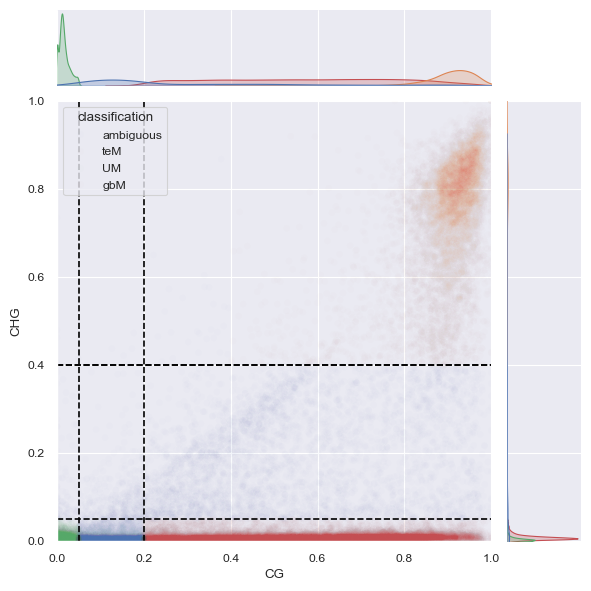

In [30]:
plt.figure(figsize=(5.9, 3), dpi=600)
methylation_scatter = sns.jointplot(
    (
        subfeature_methylation
        .filter(pl.col("column_3") == "exon")
    ),
    x="CG",
    y="CHG",
    hue="classification",
    alpha=0.01,
    xlim=(0, 1),
    ylim=(0, 1),
)
# Need to plot some guides for the cutoffs
plt.axvline(0.05, color="black", linestyle="--")
plt.axhline(0.05, color="black", linestyle="--")
plt.axvline(0.2, color="black", linestyle="--")
plt.axhline(0.4, color="black", linestyle="--")
plt.axhline(0.4, color="black", linestyle="--")
plt.savefig("../../pandoc-thesis/figures/methylation_scatterplot.png")

Aight fam lets check the tpm levels

certified lover boy certifed WAP WAP WAP WAP

                            OLS Regression Results                            
Dep. Variable:                log_tpm   R-squared:                       0.351
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                 3.537e+04
Date:                Sun, 16 Jun 2024   Prob (F-statistic):               0.00
Time:                        16:38:50   Log-Likelihood:            -6.5638e+05
No. Observations:              457232   AIC:                         1.313e+06
Df Residuals:                  457224   BIC:                         1.313e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.5936      0.004    446.251      0.0

<Axes: xlabel='log_tpm', ylabel='condition'>

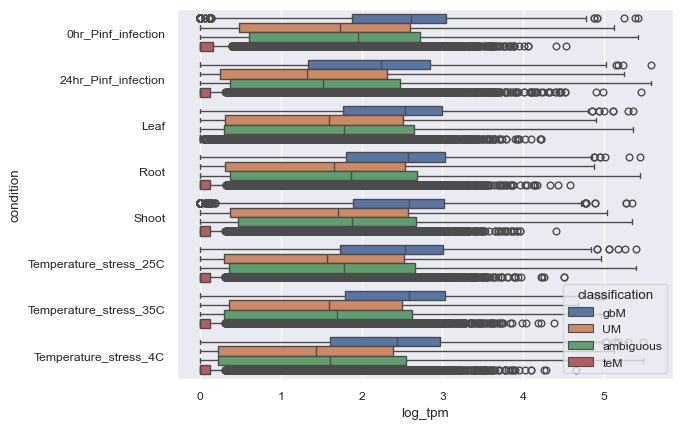

In [23]:
lcpm = (
    pl.read_csv(
        "../results/tpm.tsv",
        separator="\t",
        has_header=True,
    )
    .with_columns((pl.col("tpm") + 1).log10().alias("log_tpm"))
)

merged = (
    lcpm
    .join(subfeature_methylation, on="gene", how="left")
)

mod = smf.ols(
    "log_tpm ~ CG * CHG * CHH",
    data=merged.to_pandas(),
)
res = mod.fit()
print(res.summary())

sns.boxplot(
    merged,
    y="condition",
    x="log_tpm",
    hue="classification"
)